_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [51]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import random
from matplotlib.pyplot import cm
import numpy as np
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import category_encoders as ce
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [2]:


train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encodeinspections._rs, sklearn.preprocessing, or any other library.)


In [31]:
train.head().T

,0,1,2,3,4
Inspection ID,2088270,555268,1751394,1763905,453326
DBA Name,"TOM YUM RICE & NOODLE, INC.",FILLING STATION & CONVENIENCE STORE,A P DELI,FRANK'S CHICAGO SHRIMP HOUSE,MORRILL
AKA Name,TOM YUM CAFE,FILLING STATION & CONVENIENCE STORE,A P DELI,FRANK'S CHICAGO SHRIMP HOUSE,MORRILL
License #,2.35491e+06,1.0449e+06,47405,6414,24571
Facility Type,Restaurant,Grocery Store,Restaurant,Restaurant,School
Risk,Risk 1 (High),Risk 3 (Low),Risk 1 (High),Risk 2 (Medium),Risk 1 (High)
Address,608 W BARRY,6646-6658 S WESTERN AVE,2025 E 75TH ST,4459 S ARCHER AVE,6011 S Rockwell (2600W) AVE
City,CHICAGO,CHICAGO,CHICAGO,CHICAGO,CHICAGO
State,IL,IL,IL,IL,IL
Zip,60657,60636,60649,60632,60629


In [32]:
train.columns.tolist()

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Violations',
 'Latitude',
 'Longitude',
 'Location',
 'Fail']

In [100]:
train['Fail'].mean()#Baseline

0.25861006240850604

In [101]:
train_d = train.drop(columns=['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Violations',
 'Latitude',
 'Longitude',
 'Location'])

In [102]:
train_d.isnull().sum().sort_values()

Address              0
Inspection Date      0
Fail                 0
Inspection Type      1
State               10
Risk                12
Zip                 26
City                53
Facility Type      224
dtype: int64

In [103]:
train_d.columns.tolist()

['Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Fail']

In [104]:
features = ['Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type']
target = 'Fail'

preprocessor = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())#sex is assigned integers with ordinal encoder
X = preprocessor.fit_transform(train_d[features])
X = pd.DataFrame(X, columns=features)
y = train_d[target]

X.head()

,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type
0,1.0,1.0,1.0,1.0,1.0,60657.0,1.0,1.0
1,2.0,2.0,2.0,1.0,1.0,60636.0,2.0,2.0
2,1.0,1.0,3.0,1.0,1.0,60649.0,3.0,3.0
3,1.0,3.0,4.0,1.0,1.0,60632.0,4.0,1.0
4,3.0,1.0,5.0,1.0,1.0,60629.0,5.0,1.0


In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=42)

In [106]:
X_train, X_val, y_train, y_val = train_test_split(#Manual Cross Validation
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [107]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((29072, 8), (12460, 8), (10384, 8), (29072,), (12460,), (10384,))

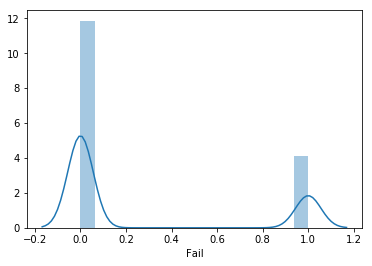

In [108]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [109]:
scores = cross_validate(LogisticRegression(), X_train, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 3,#higher numbers may have more variance, could be 5 or 7, computational time increases
                        return_train_score = True, return_estimator = True)#we return training scores

C:\Users\lilyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lilyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lilyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [110]:
# Random Forest Regressor - this is a regressor problem
from sklearn. ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1)#Instantiating Random Forest Regressor Object

scores = cross_validate(model, X_train, y_train,#doing cross validation with random forest
                        scoring='neg_mean_absolute_error',
                        cv=3, return_train_score=True,
                        return_estimator=True)
pd.DataFrame(scores)
#random forest not performing as well as linear regression

,fit_time,score_time,estimator,test_score,train_score
0,3.434002,0.103880,"(DecisionTreeRegressor(criterion='mse', max_de...",-0.349268,-0.128794
1,1.297531,0.107140,"(DecisionTreeRegressor(criterion='mse', max_de...",-0.349789,-0.128680
2,1.314487,0.104327,"(DecisionTreeRegressor(criterion='mse', max_de...",-0.347894,-0.129123


In [111]:
# recommended to search with highest validation score, gridsearch will exhaustively consider all parameters
#Gridsearch may take a long time, to get an incrementally better score
# RandomizedSearch CV can sample a given number of candidates
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
     'n_estimators': [50],
     'max_depth': [10],
     'criterion': ['mse', 'mae']
}#I can try different options for my pipeline
#in real world, you will have more parameter values

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),#parameters, what are the estimators we are using
    param_distributions=param_distributions,
    n_iter = 8,#if that took too long, can try like 4, tradeoff of runtime to optimization of solution
    #grid search would take too long, Randomized Search is faster
    #at 8 iterations, this equals grid search
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,#operate where it's at, because it might take too long
    return_train_score=True
)

gridsearch.fit(X_train, y_train)
#n_iter trades off runtime vs quality of solution
#criterion measure quality of split using mean squared error or mean absolute error, not going to make a huge difference 

C:\Users\lilyx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=8. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=50, max_depth=10, criterion=mse ....................
[CV]  n_estimators=50, max_depth=10, criterion=mse, score=-0.35048750788317956, total=   0.5s
[CV] n_estimators=50, max_depth=10, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=50, max_depth=10, criterion=mse, score=-0.3517532254123791, total=   0.5s
[CV] n_estimators=50, max_depth=10, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  n_estimators=50, max_depth=10, criterion=mse, score=-0.3490563438147355, total=   0.5s
[CV] n_estimators=50, max_depth=10, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 10, 20]#try a range of values for these parameters
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');
#like training with max-depth 2, train with 3, 4 etc

In [ ]:
param_distributions = {#decalre dictionary
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True
)

search.fit(X_train, y_train)

In [ ]:
print('MeanBasolute Error with Cross-Validation')
print(f' Predictions are off by: {int(-search.best_score_)} bicyclicsts per day, on average')

In [ ]:
print('MeanBasolute Error with Cross-Validation')
print(f' Predictions are off by: {int(-search.best_score_)} bicyclicsts per day, on average')

In [47]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').tail()# worst 5 candidates - the thing they had in common is a max_depth of 1 maybe too shallow

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
20,1.125156,0.091086,0.015845,0.002448,1,193,"{'max_depth': 1, 'n_estimators': 193}",-0.360860,-0.361429,-0.359029,-0.360440,0.001024,46,-0.360233,-0.359115,-0.360511,-0.359953,0.000603
36,0.702947,0.100299,0.012966,0.002443,1,118,"{'max_depth': 1, 'n_estimators': 118}",-0.363666,-0.364076,-0.361926,-0.363223,0.000932,47,-0.363287,-0.361942,-0.363626,-0.362952,0.000727
17,0.577124,0.052649,0.016955,0.004232,1,92,"{'max_depth': 1, 'n_estimators': 92}",-0.365089,-0.365690,-0.363546,-0.364775,0.000903,48,-0.364837,-0.363597,-0.365275,-0.364570,0.000711
10,0.364692,0.045865,0.012633,0.004485,1,69,"{'max_depth': 1, 'n_estimators': 69}",-0.366963,-0.367578,-0.365575,-0.366706,0.000838,49,-0.366730,-0.365510,-0.367331,-0.366523,0.000758
47,0.297538,0.006220,0.015293,0.003083,1,62,"{'max_depth': 1, 'n_estimators': 62}",-0.367917,-0.368312,-0.366618,-0.367616,0.000724,50,-0.367760,-0.366276,-0.368303,-0.367446,0.000857


In [20]:
pd.Series(search.best_estimator_.feature_importances_, X_train.columns)#throwing number in pandas series

Facility Type      0.110028
Risk               0.034819
Address            0.289694
City               0.008047
State              0.000000
Zip                0.172392
Inspection Date    0.269421
Inspection Type    0.115599
dtype: float32

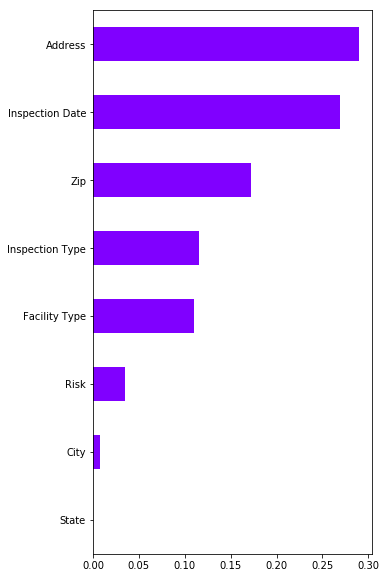

In [24]:
import random
from matplotlib.pyplot import cm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color = iter(cm.rainbow(np.linspace(-1.1,1.5))));

In [66]:
%matplotlib inline
from IPython.display import display
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


n_samples = 1000
weights = (0.75, 0.25)#we are generating data that is 95% one class, 5% another class
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = 'balanced'#{0: 1, 1:10000}means make the positive 10,000 times more weight
#default parameter for Logistic Regression, we rebalance in next cell

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))
display(pd.DataFrame(
    confusion_matrix(y_val, y_pred), 
    columns=['Predicted Negative', 'Predicted Positive'], 
    index=['Actual Negative', 'Actual Positive']))


y_pred_proba = model.predict_proba(X_val)[:,1]
print('ROC AUC', roc_auc_score(y_val, y_pred_proba))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        79
           1       0.83      0.90      0.86        21

   micro avg       0.94      0.94      0.94       100
   macro avg       0.90      0.93      0.91       100
weighted avg       0.94      0.94      0.94       100

accuracy 0.94


,Predicted Negative,Predicted Positive
Actual Negative,75,4
Actual Positive,2,19


ROC AUC 0.9517781796262809


In [68]:
threshold = 0.75
y_pred = y_pred_proba >= threshold

print(classification_report(y_val, y_pred))

pd.DataFrame(confusion_matrix(y_val, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        79
           1       0.94      0.71      0.81        21

   micro avg       0.93      0.93      0.93       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.93      0.93      0.93       100



,Predicted Negative,Predicted Positive
Actual Negative,78,1
Actual Positive,6,15


_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future 



*   Leakage is when data that should not inform the training dataset is involved. This data would not be available in the test set in the actual scenario. An example of leakage is when predicting the future, data from the future is being used to inform the model that in the real world test case, may not be available. 



### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [88]:
X_test_permuted = X_test.copy()#Make a copy
preprocessor = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())#sex is assigned integers with ordinal encoder
X_test_permuted = preprocessor.fit_transform(train_d[features])
X_test_permuted = pd.DataFrame(X_test_permuted, columns=features)

In [90]:

X_test_permuted.head(2)

,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type
0,1.0,1.0,1.0,1.0,1.0,60657.0,1.0,1.0
1,2.0,2.0,2.0,1.0,1.0,60636.0,2.0,2.0




### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?


*   Gradient Descent seeks to minimize the error produced by a model given features being weighted a certain amount. 


- What is the "Learning Rate" and what is its function?

*   The learning rate is the derivative of a plotted point in a graph of the errors vs feature importances. The derivative is the slope, which informs the direction that the feature weights should be adjusted in order to achieve a smaller error weight. As the error rate approaches zero, the local minima is discovered. Trying multiple values of feature weights across large enough steps informs the global minimum than just the local minima. 

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._